<a href="https://colab.research.google.com/github/Tikogrk/Kaggle_Tissot/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22Untitled3_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas
!pip install nlpaug
!pip install sklearn
!pip install spacy
!pip install sentencepiece
!pip install torch
!pip install transformers
!pip install matplotlib
!pip install numpy
!pip install catboost
# Import standard libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import math
from collections import defaultdict
import tqdm
import warnings
warnings.filterwarnings('ignore')

# Import for text analytics
import spacy
from spacy import displacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
import string
import gensim
from gensim.models import Word2Vec
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from gensim.models import LdaModel, CoherenceModel, TfidfModel
from gensim.corpora import Dictionary
from gensim.utils import simple_preprocess
from gensim import corpora
import sentencepiece
import torch
import torch.nn as nn
from torch.optim import Adam
from transformers import CamembertTokenizer, CamembertModel
from transformers import AutoModel, AutoTokenizer
from transformers import BertTokenizer, BertModel
from transformers import FlaubertModel, FlaubertTokenizer
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas

# Import for classification
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix # Confusion matrix
import joblib
device = torch.device('mps')

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 12.3 MB/s eta 0:00:00


# **Data preparation and cleaning**

In [ ]:
train_ori = pd.read_csv('/content/training_data (1).csv').drop(columns=['id'])
test = pd.read_csv('/content/unlabelled_test_data (1).csv').drop(columns=['id'])

In [ ]:
train_other = pd.read_csv('/content/max-dataset.csv').rename(columns={'Text':'sentence', 'Difficulty':'difficulty'})
train_other

,sentence,difficulty
0,Je recherche une personne pour garder mes enfa...,A1
1,Il faut être disponible pour travailler les je...,A1
2,Vous devez habiter dans le centre de Limoges o...,A1
3,Expérience avec les enfants souhaitée.,A1
4,"Si vous êtes intéressé, appelez-moi.",A1
...,...,...
9169,"La vieille acquiesça de la tête, sous sa grand...",C2
9170,Il fallait qu’il débitât les nouvelles apprise...,C2
9171,"Vous eussiez dit deux éclairs bleuâtres, parei...",C2
9172,Elle dénoua le ruban qui attachait le manche d...,C2


In [ ]:
display(train_ori)
display(test)


,sentence,difficulty
0,Les coûts kilométriques réels peuvent diverger...,C1
1,"Le bleu, c'est ma couleur préférée mais je n'a...",A1
2,Le test de niveau en français est sur le site ...,A1
3,Est-ce que ton mari est aussi de Boston?,A1
4,"Dans les écoles de commerce, dans les couloirs...",B1
...,...,...
4795,"C'est pourquoi, il décida de remplacer les hab...",B2
4796,Il avait une de ces pâleurs splendides qui don...,C1
4797,"Et le premier samedi de chaque mois, venez ren...",A2
4798,Les coûts liés à la journalisation n'étant pas...,C2


,sentence
0,Nous dûmes nous excuser des propos que nous eû...
1,Vous ne pouvez pas savoir le plaisir que j'ai ...
2,"Et, paradoxalement, boire froid n'est pas la b..."
3,"Ce n'est pas étonnant, car c'est une saison my..."
4,"Le corps de Golo lui-même, d'une essence aussi..."
...,...
1195,C'est un phénomène qui trouve une accélération...
1196,Je vais parler au serveur et voir si on peut d...
1197,Il n'était pas comme tant de gens qui par pare...
1198,Ils deviennent dangereux pour notre économie.


In [ ]:
train = pd.concat([train_other, train_ori])
train = train.drop_duplicates()
train = train.sample(frac=1, random_state=42).reset_index(drop=True)
train

,sentence,difficulty
0,La moto devint une marque distinctive de liber...,B2
1,Il est employé,A1
2,Je suis bien arrivé à Londres.,A2
3,La cinquantaine marque une rupture dans la vie...,C1
4,Elle parle anglais et français et elle étudie ...,A1
...,...,...
10866,Au moins sept manifestants pro-démocratie ont ...,C1
10867,"Je vais être en retard ce soir, peux-tu prépar...",B2
10868,Ma famille se compose de quatre personnes,A1
10869,"Depuis qu’elles se sont diversifiées, au moins...",C1


# **Exploratory Data Analysis**

In [ ]:
# Create a new column to store the length of the texts
train['sentence length'] = train['sentence'].apply(lambda x: len(str(x)))
train

,sentence,difficulty,sentence length
0,La moto devint une marque distinctive de liber...,B2,82
1,Il est employé,A1,14
2,Je suis bien arrivé à Londres.,A2,30
3,La cinquantaine marque une rupture dans la vie...,C1,145
4,Elle parle anglais et français et elle étudie ...,A1,56
...,...,...,...
10866,Au moins sept manifestants pro-démocratie ont ...,C1,274
10867,"Je vais être en retard ce soir, peux-tu prépar...",B2,71
10868,Ma famille se compose de quatre personnes,A1,41
10869,"Depuis qu’elles se sont diversifiées, au moins...",C1,115


In [ ]:
train_mean_length = train.groupby(['difficulty']).mean().reset_index().rename(columns={'sentence length': 'mean length'})
train_count = train.groupby(['difficulty']).count().reset_index().drop(columns=['sentence']).rename(columns={'sentence length': 'count'})
train_eda = train_mean_length.merge(train_count, on='difficulty')
train_eda

,difficulty,mean length,count
0,A1,42.898670,1579
1,A2,64.973542,2041
2,B1,88.757473,1773
3,B2,116.749716,1758
4,C1,147.102167,1938
5,C2,201.145342,1782


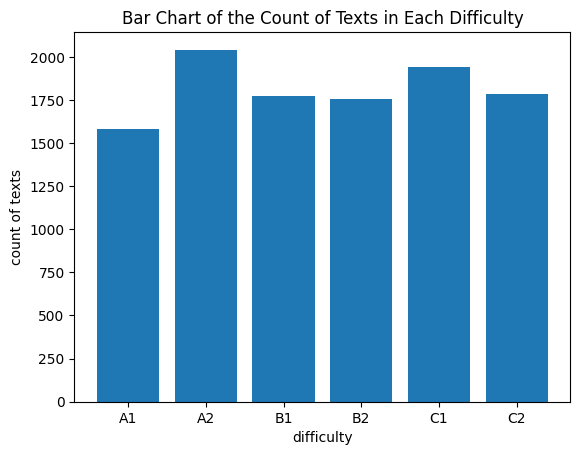

In [ ]:
# Draw the bar chart of the count of texts in each difficulty
plt.bar(train_eda['difficulty'], train_eda['count'])
plt.title('Bar Chart of the Count of Texts in Each Difficulty')
plt.xlabel('difficulty')
plt.ylabel('count of texts')

plt.show()

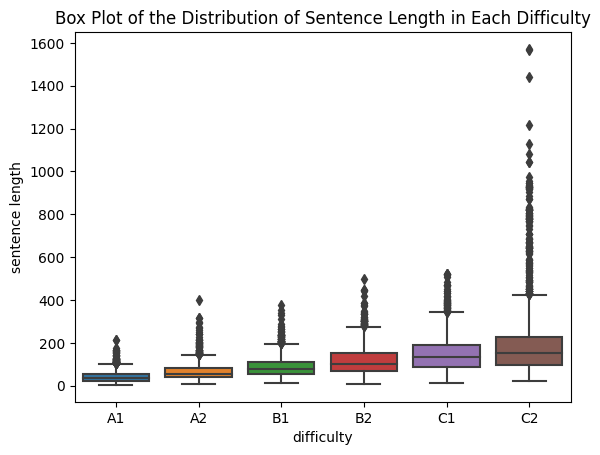

In [ ]:
# Draw the box plot
sns.boxplot(x='difficulty', y='sentence length', data=train, order=['A1', 'A2', 'B1', 'B2', 'C1', 'C2'])

plt.title("Box Plot of the Distribution of Sentence Length in Each Difficulty")
plt.xlabel("difficulty")
plt.ylabel("sentence length")

plt.show()

In [ ]:
# Create X and y for the model training
X = train['sentence']
y = train['difficulty']

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 46.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 57.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 37.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 40.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 37.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


# **Text difficulty classification**

# **Bert: Tokenization and Text Feature Extraction**

In [ ]:
# Cambert model
tokenizer = CamembertTokenizer.from_pretrained('camembert-base')
model = CamembertModel.from_pretrained('camembert-base', num_labels=6).to(device)

# Flaubert model
# tokenizer = FlaubertTokenizer.from_pretrained('flaubert/flaubert_base_cased')
# model = FlaubertModel.from_pretrained('flaubert/flaubert_base_cased', num_labels=6).to(device)

# Multilingual model
# tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
# model = BertModel.from_pretrained('bert-base-multilingual-cased', num_labels=6).to(device)

def bert_feature(data, **kwargs):
    # Tokenize and encode input texts
    input_ids = [tokenizer.encode(text, add_special_tokens=True, **kwargs) for text in data]

    # Extract BERT features for each input ID
    features = []
    with torch.no_grad():
        for input_id in tqdm.tqdm(input_ids):
            # Convert input ID to tensor
            input_tensor = torch.tensor(input_id).unsqueeze(0).to(device)

            # Extract BERT features for this input ID
            input_embeds = model.embeddings(input_tensor)
            feature = model(inputs_embeds=input_embeds)[0][:, 0, :].cpu().numpy()

            # Add feature to list of all features
            features.append(feature)

    # Concatenate features from all inputs
    feature_data = np.concatenate(features, axis=0)

    torch.cuda.empty_cache()

    return feature_data

sentencepiece.bpe.model:   0%|          | 0.00/811k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/508 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

In [ ]:
X = bert_feature(X)

100%|██████████| 10871/10871 [01:47<00:00, 101.07it/s]


In [ ]:
# Display the outcome after the feature extraction
pd.DataFrame(X)

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.009658,0.204015,0.066227,-0.054740,0.067690,-0.099764,-0.021509,0.194520,0.083554,0.073023,...,-0.104705,-0.057352,-0.293228,0.125889,0.064609,0.002787,0.039208,-0.065193,0.047916,-0.057475
1,0.004873,0.094215,0.107688,-0.127375,-0.078371,0.006411,0.002899,0.211890,0.009665,0.030050,...,-0.085537,0.011440,-0.165533,0.098862,0.001680,0.083010,0.089971,-0.056786,-0.043223,-0.128083
2,-0.008067,0.076027,0.129097,-0.065913,-0.002792,0.087863,0.027575,0.231411,-0.040903,0.120860,...,-0.055491,-0.022552,-0.150907,0.123795,0.048559,0.064020,0.111041,-0.050249,0.018295,-0.031134
3,-0.034347,0.094695,-0.041662,-0.050720,-0.119592,-0.073223,0.006999,0.249484,0.016757,0.070269,...,-0.017139,-0.129802,-0.122003,0.101528,-0.017249,0.069578,0.027919,-0.036510,0.066399,-0.072213
4,-0.019092,0.073252,0.108718,-0.125545,-0.039069,-0.008434,-0.015010,0.263034,0.008885,0.177239,...,-0.018939,0.004761,-0.151420,0.108461,0.123691,0.075781,0.022834,-0.067982,-0.021448,-0.031718
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10866,0.015121,0.166713,0.114754,-0.093979,-0.022310,0.025477,-0.067050,0.258020,-0.032255,0.124273,...,-0.013918,-0.155388,-0.185953,0.120019,0.030759,-0.015543,0.013821,-0.131124,0.024897,-0.001089
10867,-0.029814,0.061035,0.143973,-0.036999,-0.041943,0.049765,0.017360,0.308143,0.033816,0.150243,...,-0.044106,-0.008457,-0.094575,0.120174,0.000506,0.070414,0.038460,-0.127833,0.067543,0.035968
10868,0.015691,0.118440,0.052074,-0.126597,-0.016131,-0.075390,0.001682,0.339817,-0.026803,0.111593,...,-0.102620,0.034236,-0.155104,0.036178,0.054890,0.079816,-0.002565,-0.077096,-0.084497,-0.084767
10869,-0.047853,0.116697,0.088597,-0.042536,-0.072561,-0.040959,0.013786,0.271830,-0.019716,0.075964,...,-0.025039,-0.120551,-0.141868,0.123347,0.052299,0.167325,-0.002250,0.039464,0.025090,-0.018311


# **Compare classification models**

In [ ]:
def evaluation(model, X_test, y_test):
    y_pred = model.predict(X_test)
    model_accuracy = accuracy_score(y_test, y_pred)
    model_precision = precision_score(y_test, y_pred, average='macro')
    model_recall = recall_score(y_test, y_pred, average='macro')
    model_f1 = f1_score(y_test, y_pred, average='macro')
    model_eval = [model_accuracy, model_precision, model_recall, model_f1]
    return model_eval

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [ ]:
# Define the encoder
le = LabelEncoder()
# Fit the encoder
le.fit(y_train)

y_train = le.transform(y_train)
y_test = le.transform(y_test)

In [ ]:
model_comparison = pd.DataFrame(index=['Accuracy', 'Precision', 'Recall', 'F1'])

In [ ]:
svc_model = SVC(C=1, kernel='rbf', gamma='scale')
svc_model.fit(X_train, y_train)

model_comparison['SVC'] = evaluation(svc_model, X_test, y_test)
model_comparison

,SVC
Accuracy,0.506434
Precision,0.514941
Recall,0.504060
F1,0.505178


In [ ]:
knn_model = KNeighborsClassifier(algorithm="kd_tree")
knn_model.fit(X_train,y_train)

model_comparison['KNN'] = evaluation(knn_model, X_test, y_test)
model_comparison

,SVC,KNN
Accuracy,0.506434,0.539522
Precision,0.514941,0.557518
Recall,0.504060,0.541675
F1,0.505178,0.541022


In [ ]:
logi_model = LogisticRegression()
logi_model.fit(X_train,y_train)

model_comparison['Logistic Regression'] = evaluation(logi_model, X_test, y_test)
model_comparison

,SVC,KNN,Logistic Regression
Accuracy,0.506434,0.539522,0.534926
Precision,0.514941,0.557518,0.537736
Recall,0.504060,0.541675,0.537190
F1,0.505178,0.541022,0.536439


In [ ]:
rfc_model = RandomForestClassifier(random_state=42)
rfc_model.fit(X_train,y_train)

model_comparison['Random Forest'] = evaluation(rfc_model, X_test, y_test)
model_comparison

,SVC,KNN,Logistic Regression,Random Forest
Accuracy,0.506434,0.539522,0.534926,0.577206
Precision,0.514941,0.557518,0.537736,0.586686
Recall,0.504060,0.541675,0.537190,0.578026
F1,0.505178,0.541022,0.536439,0.580477


Other codes to apply if needed

In [ ]:
rfc_model_best = RandomForestClassifier(max_depth=None, min_samples_split=2, n_estimators=300, random_state=42)
rfc_model_best.fit(X_train,y_train)

model_comparison['Random Forest (best para)'] = evaluation(rfc_model_best, X_test, y_test)
model_comparison

,SVC,KNN,Logistic Regression,Random Forest,Random Forest (best para)
Accuracy,0.506434,0.539522,0.534926,0.577206,0.608456
Precision,0.514941,0.557518,0.537736,0.586686,0.622391
Recall,0.504060,0.541675,0.537190,0.578026,0.608895
F1,0.505178,0.541022,0.536439,0.580477,0.612535


In [ ]:
etc_model = ExtraTreesClassifier(random_state=42)
etc_model.fit(X_train,y_train)

model_comparison['Extra Trees'] = evaluation(etc_model, X_test, y_test)
model_comparison

,SVC,KNN,Logistic Regression,Random Forest,Random Forest (best para),Extra Trees
Accuracy,0.506434,0.539522,0.534926,0.577206,0.608456,0.601103
Precision,0.514941,0.557518,0.537736,0.586686,0.622391,0.610362
Recall,0.504060,0.541675,0.537190,0.578026,0.608895,0.602210
F1,0.505178,0.541022,0.536439,0.580477,0.612535,0.604865


In [ ]:
etc_model_best = ExtraTreesClassifier(min_samples_leaf=1, min_samples_split=2, n_estimators=300, random_state=42)
etc_model_best.fit(X_train,y_train)

model_comparison['Extra Trees (best para)'] = evaluation(etc_model_best, X_test, y_test)
model_comparison

,SVC,KNN,Logistic Regression,Random Forest,Random Forest (best para),Extra Trees,Extra Trees (best para)
Accuracy,0.506434,0.539522,0.534926,0.577206,0.608456,0.601103,0.619485
Precision,0.514941,0.557518,0.537736,0.586686,0.622391,0.610362,0.634510
Recall,0.504060,0.541675,0.537190,0.578026,0.608895,0.602210,0.619107
F1,0.505178,0.541022,0.536439,0.580477,0.612535,0.604865,0.622674


In [ ]:
lgb_model = LGBMClassifier()
lgb_model.fit(X_train,y_train)

model_comparison['LightGBM'] = evaluation(lgb_model, X_test, y_test)
model_comparison

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054563 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 9783, number of used features: 768
[LightGBM] [Info] Start training from score -1.939186
[LightGBM] [Info] Start training from score -1.676330
[LightGBM] [Info] Start training from score -1.810643
[LightGBM] [Info] Start training from score -1.823854
[LightGBM] [Info] Start training from score -1.719888
[LightGBM] [Info] Start training from score -1.801311


,SVC,KNN,Logistic Regression,Random Forest,Random Forest (best para),Extra Trees,Extra Trees (best para),LightGBM
Accuracy,0.506434,0.539522,0.534926,0.577206,0.608456,0.601103,0.619485,0.595588
Precision,0.514941,0.557518,0.537736,0.586686,0.622391,0.610362,0.634510,0.607567
Recall,0.504060,0.541675,0.537190,0.578026,0.608895,0.602210,0.619107,0.596448
F1,0.505178,0.541022,0.536439,0.580477,0.612535,0.604865,0.622674,0.600532


In [ ]:
lgb_model_best = LGBMClassifier(learning_rate=0.2, max_depth=7)
lgb_model_best.fit(X_train,y_train)

model_comparison['LightGBM (best para)'] = evaluation(lgb_model_best, X_test, y_test)
model_comparison

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 9783, number of used features: 768
[LightGBM] [Info] Start training from score -1.939186
[LightGBM] [Info] Start training from score -1.676330
[LightGBM] [Info] Start training from score -1.810643
[LightGBM] [Info] Start training from score -1.823854
[LightGBM] [Info] Start training from score -1.719888
[LightGBM] [Info] Start training from score -1.801311
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

,SVC,KNN,Logistic Regression,Random Forest,Random Forest (best para),Extra Trees,Extra Trees (best para),LightGBM,LightGBM (best para)
Accuracy,0.506434,0.539522,0.534926,0.577206,0.608456,0.601103,0.619485,0.595588,0.618566
Precision,0.514941,0.557518,0.537736,0.586686,0.622391,0.610362,0.634510,0.607567,0.628976
Recall,0.504060,0.541675,0.537190,0.578026,0.608895,0.602210,0.619107,0.596448,0.618930
F1,0.505178,0.541022,0.536439,0.580477,0.612535,0.604865,0.622674,0.600532,0.622598


In [ ]:
xgb_model = XGBClassifier()
xgb_model.fit(X_train,y_train)

model_comparison['XGBoost'] = evaluation(xgb_model, X_test, y_test)
model_comparison

,SVC,KNN,Logistic Regression,Random Forest,Random Forest (best para),Extra Trees,Extra Trees (best para),LightGBM,LightGBM (best para),XGBoost
Accuracy,0.506434,0.539522,0.534926,0.577206,0.608456,0.601103,0.619485,0.595588,0.618566,0.611213
Precision,0.514941,0.557518,0.537736,0.586686,0.622391,0.610362,0.634510,0.607567,0.628976,0.620157
Recall,0.504060,0.541675,0.537190,0.578026,0.608895,0.602210,0.619107,0.596448,0.618930,0.613229
F1,0.505178,0.541022,0.536439,0.580477,0.612535,0.604865,0.622674,0.600532,0.622598,0.615996


In [ ]:
xgb_model_best = XGBClassifier(learning_rate=0.2, max_depth=9)
xgb_model_best.fit(X_train,y_train)

model_comparison['XGBoost (best para)'] = evaluation(xgb_model_best, X_test, y_test)
model_comparison

,SVC,KNN,Logistic Regression,Random Forest,Random Forest (best para),Extra Trees,Extra Trees (best para),LightGBM,LightGBM (best para),XGBoost,XGBoost (best para)
Accuracy,0.506434,0.539522,0.534926,0.577206,0.608456,0.601103,0.619485,0.595588,0.618566,0.611213,0.630515
Precision,0.514941,0.557518,0.537736,0.586686,0.622391,0.610362,0.634510,0.607567,0.628976,0.620157,0.636936
Recall,0.504060,0.541675,0.537190,0.578026,0.608895,0.602210,0.619107,0.596448,0.618930,0.613229,0.631727
F1,0.505178,0.541022,0.536439,0.580477,0.612535,0.604865,0.622674,0.600532,0.622598,0.615996,0.633431


In [ ]:
cb_model_bert = CatBoostClassifier()
cb_model_bert.fit(X_train,y_train)

model_comparison['Catboost'] = evaluation(cb_model_bert, X_test, y_test)
model_comparison


Learning rate set to 0.088887
0:	learn: 1.7455357	total: 396ms	remaining: 6m 35s
1:	learn: 1.7113542	total: 699ms	remaining: 5m 48s
2:	learn: 1.6773239	total: 1.01s	remaining: 5m 35s
3:	learn: 1.6472084	total: 1.31s	remaining: 5m 27s
4:	learn: 1.6207444	total: 1.63s	remaining: 5m 24s
5:	learn: 1.5941646	total: 1.95s	remaining: 5m 23s
6:	learn: 1.5755368	total: 2.25s	remaining: 5m 19s
7:	learn: 1.5533006	total: 2.55s	remaining: 5m 16s
8:	learn: 1.5360271	total: 2.87s	remaining: 5m 15s
9:	learn: 1.5215833	total: 3.18s	remaining: 5m 14s
10:	learn: 1.5064100	total: 3.48s	remaining: 5m 12s
11:	learn: 1.4929047	total: 3.78s	remaining: 5m 10s
12:	learn: 1.4772639	total: 4.09s	remaining: 5m 10s
13:	learn: 1.4649615	total: 4.39s	remaining: 5m 9s
14:	learn: 1.4535872	total: 4.68s	remaining: 5m 7s
15:	learn: 1.4418820	total: 4.96s	remaining: 5m 4s
16:	learn: 1.4309738	total: 5.24s	remaining: 5m 2s
17:	learn: 1.4219355	total: 5.51s	remaining: 5m
18:	learn: 1.4130403	total: 5.78s	remaining: 4m 58s


,SVC,KNN,Logistic Regression,Random Forest,Random Forest (best para),Extra Trees,Extra Trees (best para),LightGBM,LightGBM (best para),XGBoost,XGBoost (best para),Catboost
Accuracy,0.506434,0.539522,0.534926,0.577206,0.608456,0.601103,0.619485,0.595588,0.618566,0.611213,0.630515,0.602941
Precision,0.514941,0.557518,0.537736,0.586686,0.622391,0.610362,0.634510,0.607567,0.628976,0.620157,0.636936,0.613055
Recall,0.504060,0.541675,0.537190,0.578026,0.608895,0.602210,0.619107,0.596448,0.618930,0.613229,0.631727,0.604342
F1,0.505178,0.541022,0.536439,0.580477,0.612535,0.604865,0.622674,0.600532,0.622598,0.615996,0.633431,0.607512


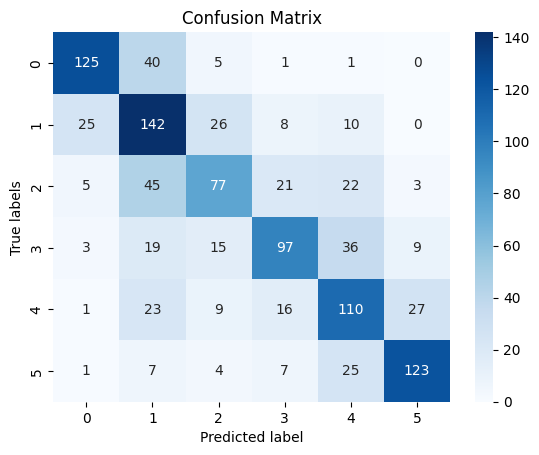

In [ ]:
# Draw the confusion matrix
sns.heatmap(confusion_matrix(y_test, etc_model_best.predict(X_test)), annot=True, cmap='Blues', fmt='.4g')
plt.xlabel('Predicted label')

plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Print precision, recall, F1 score for each label
report = classification_report(y_test, etc_model_best.predict(X_test))
print(report)

              precision    recall  f1-score   support

           0       0.78      0.73      0.75       172
           1       0.51      0.67      0.58       211
           2       0.57      0.45      0.50       173
           3       0.65      0.54      0.59       179
           4       0.54      0.59      0.56       186
           5       0.76      0.74      0.75       167

    accuracy                           0.62      1088
   macro avg       0.63      0.62      0.62      1088
weighted avg       0.63      0.62      0.62      1088



In [ ]:
# Use sanity checks
etc_model_best.predict(bert_feature([['Je suis Jean'],['Je suis Michalis']]))

100%|██████████| 2/2 [00:00<00:00, 79.61it/s]


array([0, 0])

In [ ]:
# Store the model
joblib.dump(etc_model_best, 'best_model.pkl')

['best_model.pkl']

In [ ]:
# Extract text features from test set
test_features = bert_feature(test['sentence'])

100%|██████████| 1200/1200 [00:11<00:00, 102.02it/s]


In [ ]:
preds = etc_model_best.predict(test_features)

final_DF = pd.DataFrame()
get_ID = pd.read_csv('/content/unlabelled_test_data (1).csv')
final_DF['id'] = get_ID['id']
final_DF['difficulty'] = pd.Series(preds).map({0:'A1', 1:'A2', 2:'B1', 3:'B2', 4:'C1', 5:'C2'})

Name = 'outcome.csv'
final_DF.to_csv(Name, index=0)